In [1]:
!pip install transformers

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
df = pd.read_csv('booking_reviews copy.csv')
df.shape

(26386, 15)

In [7]:
# Let's have a look at the data 
df.head()

,review,reviewed_at,reviewed_by,images,crawled_at,url,hotel_name,hotel_url,avg_rating,nationality,rating,review_text,raw_review_text,tags,meta
0,Exceptional,11 July 2021,Kyrylo,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Poland,10.0,"Everything was perfect! Quite, cozy place to r...","<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
1,I highly recommend this b&b! We enjoyed it a lot!,24 November 2019,Dimitri,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Belgium,9.0,Very friendly host and perfect breakfast!,"<p class=""review_pos ""><svg aria-label=""Positi...",Leisure trip~Couple~Deluxe Suite~Stayed 1 nigh...,"{'language': 'en-gb', 'source': 'https://www.b..."
2,Exceptional,3 January 2020,Virginia,NaN,"07/20/2021, 01:09:27",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,United Kingdom,10.0,It was just what we wanted for a week by the b...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~Couple~Apartment with Sea View~St...,"{'language': 'en-gb', 'source': 'https://www.b..."
3,My stay in the house was a experiencing bliss ...,8 September 2019,Kannan,NaN,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/villa...,Villa Pura Vida,https://www.booking.com/hotel/be/villa-pura-vi...,9.7,Netherlands,10.0,My stay in the house was a experiencing bliss ...,"<p class=""review_pos ""><svg aria-label=""Positi...",Business trip~Solo traveller~Junior Suite~Stay...,"{'language': 'en-gb', 'source': 'https://www.b..."
4,One bedroom apartment with wonderful view and ...,23 June 2019,Sue,https://cf.bstatic.com/xdata/images/xphoto/squ...,"07/20/2021, 01:09:28",https://www.booking.com/reviews/be/hotel/hydro...,Hydro Palace Apartment,https://www.booking.com/hotel/be/hydro-palace....,9.2,South Africa,9.2,The building itself has a very musty smell in ...,"<p class=""review_neg ""><svg aria-label=""Negati...",Leisure trip~People with friends~Apartment wit...,"{'language': 'en-gb', 'source': 'https://www.b..."


In [8]:
# Let's check for missing values 
df.isnull().sum()

review                 1
reviewed_at            0
reviewed_by            0
images             25632
crawled_at             0
url                    0
hotel_name             0
hotel_url              0
avg_rating             0
nationality           16
rating                 0
review_text            0
raw_review_text        0
tags                   0
meta                   0
dtype: int64

['positive', 'neutral', 'negative']


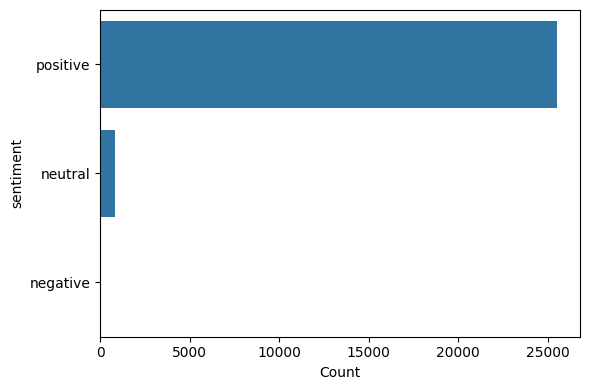

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv("booking_reviews copy.csv")

# Define thresholds for sentiment labels based on average rating
positive_threshold = 7  # Ratings above 7 are positive
negative_threshold = 4  # Ratings below 4 are negative

# Create sentiment labels based on average rating
df['sentiment'] = np.where(df['avg_rating'] >= positive_threshold, 'positive',
                           np.where(df['avg_rating'] < negative_threshold, 'negative', 'neutral'))

# Create a countplot with vertical orientation
plt.figure(figsize=(6, 4))
ax = sns.countplot(y='sentiment', data=df, order=df['sentiment'].value_counts().index, orient='h')

# Get the text labels for each sentiment category
labels = [t.get_text() for t in ax.get_yticklabels()]
print(labels)

# Adjust the layout and display the plot
plt.xlabel('Count')
plt.tight_layout()
plt.show()

In [11]:
# Set the model name
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-cased'

# Build a BERT-based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [12]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [13]:
# Store length of each review 
token_lens = []

# Iterate through the column containing review text
for txt in df['review_text']:  # Replace 'review_text' with the actual column name
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

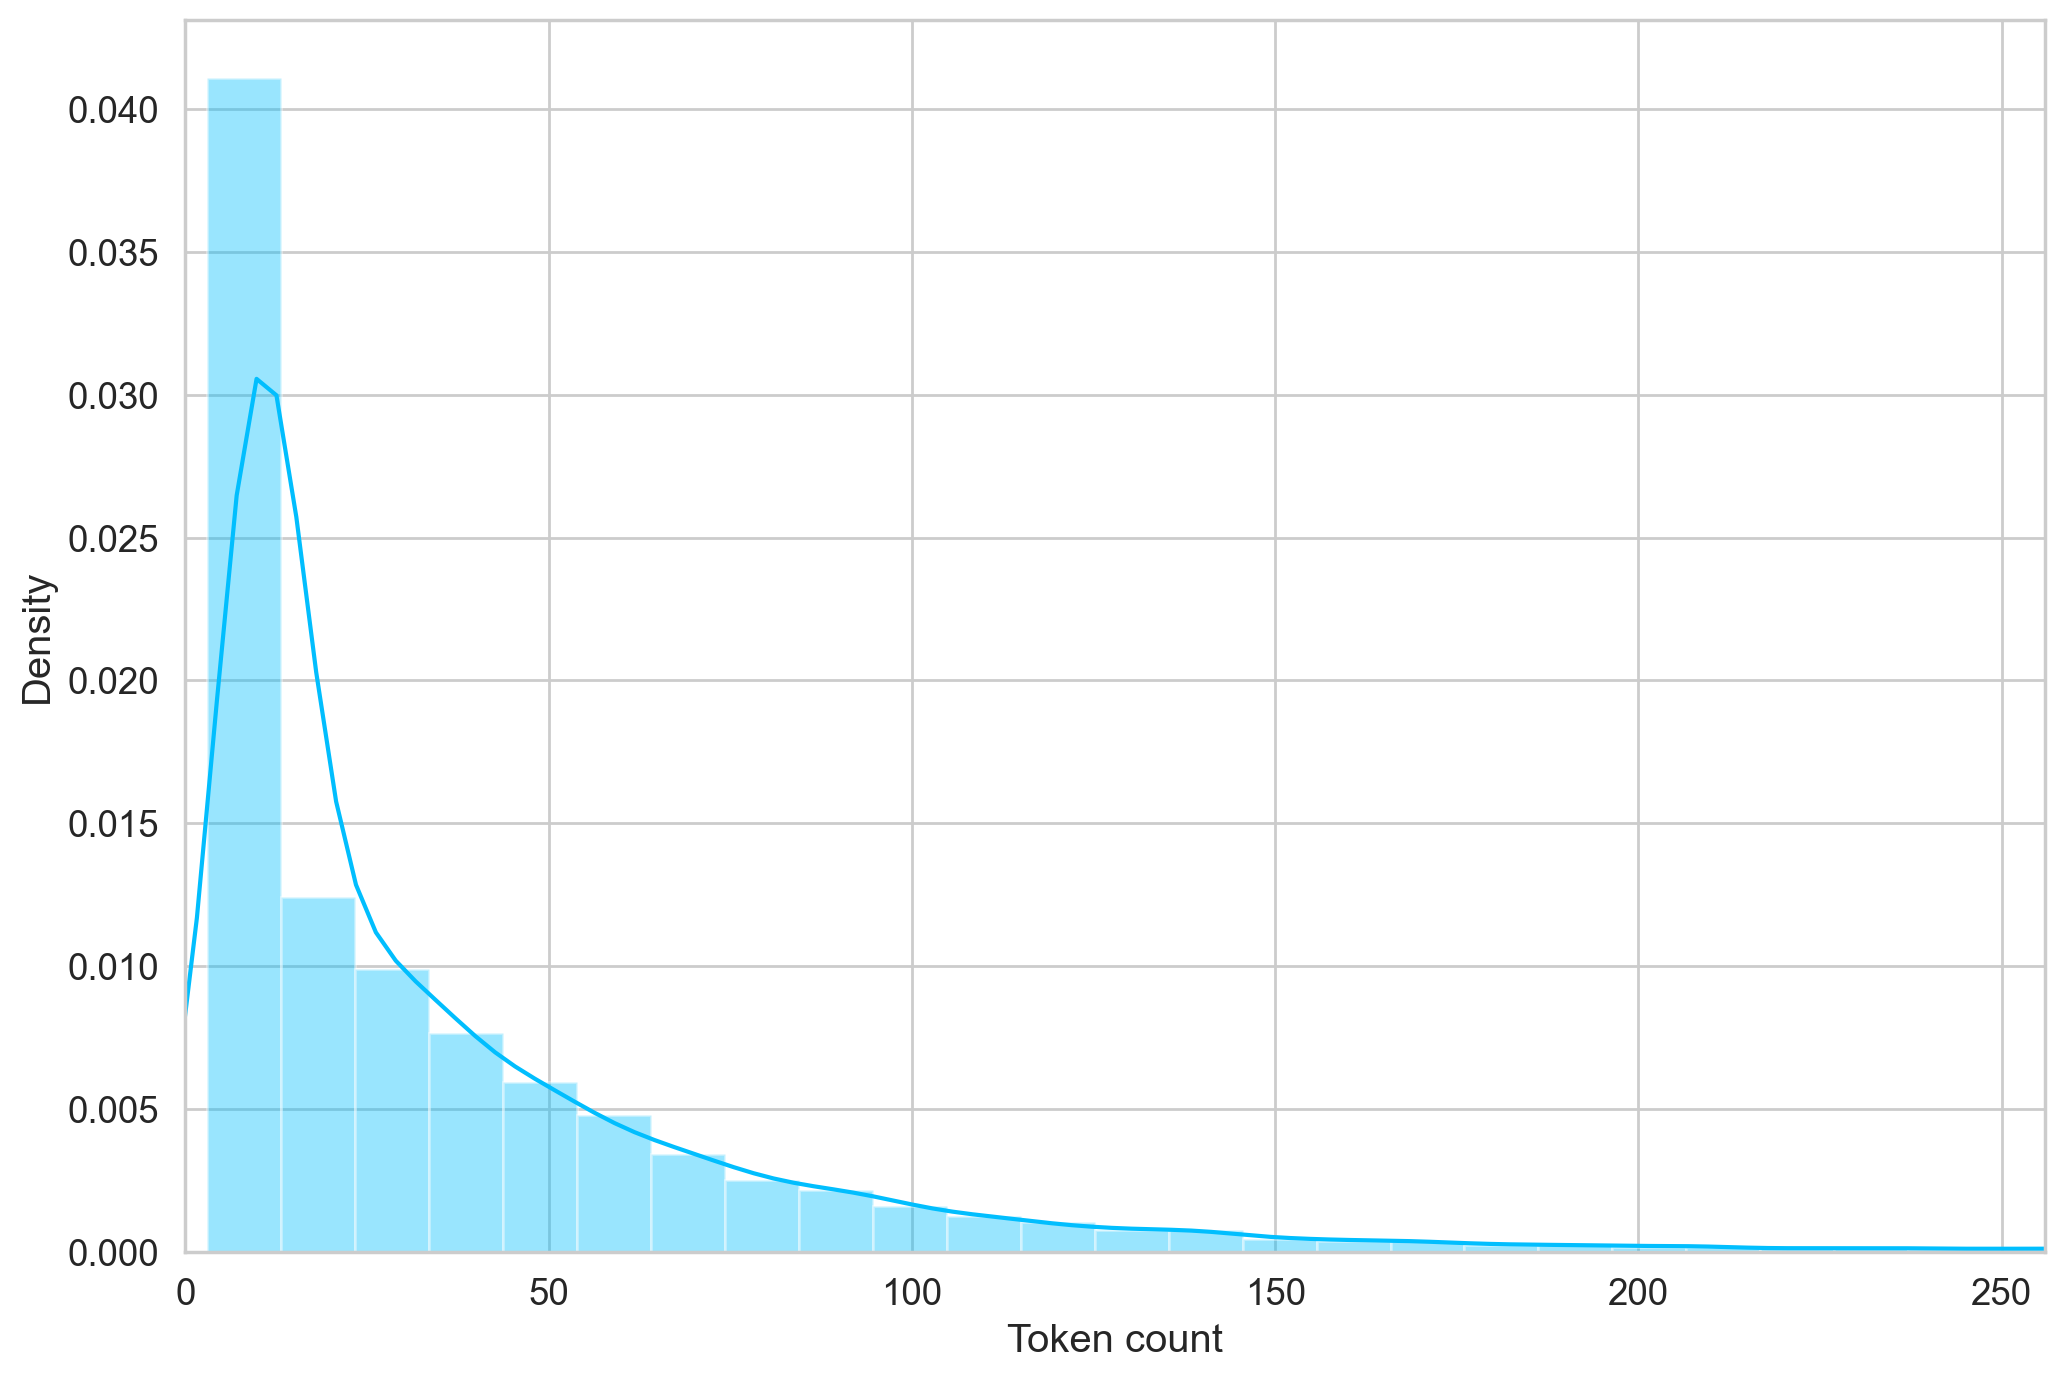

In [14]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [15]:
MAX_LEN = 160

In [16]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(21108, 15) (2639, 15) (2639, 15)


In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    reviews = df['review_text'].to_numpy()  # Adjust to your column name 'review_text'
    targets = df['rating'].to_numpy()  # Adjust to your column name representing sentiment or ratings
    ds = GPReviewDataset(
        reviews=reviews,
        targets=targets,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )



In [31]:
# Create train, test and val data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [32]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [33]:
# I am Loading the basic BERT model here
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [49]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)  # Dropout layer
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Extract pooled output (index 1)
        output = self.drop(pooled_output)  # Apply dropout
        return self.out(output)


In [50]:
# Instantiate the model and move to classifier
# Define the class names
class_names = ['negative', 'neutral', 'positive']

# Instantiate the model and move it to the specified device
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [51]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [52]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [59]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


IndexError: Target 9 is out of bounds.